# Benchmark on OGB, https://ogb.stanford.edu/docs/home/

In [2]:
import random
import argparse
import configparser
import numpy as np
import networkx as nx


import torch
import torch.nn.functional as F
import torch_sparse
from torch import Tensor
from torch.nn import Linear
from torch.utils.data import DataLoader
from torch_geometric.utils import negative_sampling, to_networkx
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator




def get_spd_matrix(G, S, max_spd=5):
    spd_matrix = np.zeros((G.number_of_nodes(), len(S)), dtype=np.float32)
    for i, node_S in enumerate(S):
        for node, length in nx.shortest_path_length(G, source=node_S).items():
            spd_matrix[node, i] = min(length, max_spd)
    return spd_matrix


class Logger(object):
    def __init__(self, runs, info=None):
        self.info = info
        self.results = [[] for _ in range(runs)]

    def add_result(self, run, result):
        assert len(result) == 2
        assert run >= 0 and run < len(self.results)
        self.results[run].append(result)

    def print_statistics(self, run=None):
        if run is not None:
            result = 100 * torch.tensor(self.results[run])
            argmax = result[:, 0].argmax().item()
            print(f'Run {run + 1:02d}:')
            print(f'Highest Valid: {result[:, 0].max():.2f}')
            print(f'   Final Test: {result[argmax, 1]:.2f}')
        else:
            result = 100 * torch.tensor(self.results)
            best_results = []
            for r in result:
                valid = r[:, 0].max().item()
                test = r[r[:, 0].argmax(), 1].item()
                best_results.append((valid, test))
            best_result = torch.tensor(best_results)
            print(f'All runs:')
            r = best_result[:, 0]
            print(f'Highest Valid: {r.mean():.4f} ± {r.std():.4f}')
            r = best_result[:, 1]
            print(f'   Final Test: {r.mean():.4f} ± {r.std():.4f}')


class SAGEConv(MessagePassing):
    r"""The GraphSAGE operator from the `"Inductive Representation Learning on
    Large Graphs" <https://arxiv.org/abs/1706.02216>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{W}_1 \mathbf{x}_i + \mathbf{W}_2 \cdot
        \mathrm{mean}_{j \in \mathcal{N(i)}} \mathbf{x}_j

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
        out_channels (int): Size of each output sample.
        normalize (bool, optional): If set to :obj:`True`, output features
            will be :math:`\ell_2`-normalized, *i.e.*,
            :math:`\frac{\mathbf{x}^{\prime}_i}
            {\| \mathbf{x}^{\prime}_i \|_2}`.
            (default: :obj:`False`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, normalize: bool = False,
                 root_weight: bool = True,
                 bias: bool = True, **kwargs):  # yapf: disable
        kwargs.setdefault('aggr', 'mean')
        super(SAGEConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.root_weight = root_weight

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_l = Linear(in_channels[0], out_channels, bias=bias)
        if self.root_weight:
            self.lin_r = Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        if self.root_weight:
            self.lin_r.reset_parameters()


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, size: Size = None) -> Tensor:
        """"""
        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        # Node and edge feature dimensionalites need to match.
        if isinstance(edge_index, Tensor):
            assert edge_attr is not None
            assert x[0].size(-1) == edge_attr.size(-1)
        elif isinstance(edge_index, SparseTensor):
            assert x[0].size(-1) == edge_index.size(-1)

        # propagate_type: (x: OptPairTensor, edge_attr: OptTensor)
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=size)
        out = self.lin_l(out)

        x_r = x[1]
        if self.root_weight and x_r is not None:
            out += self.lin_r(x_r)

        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)

        return out


    def message(self, x_j: Tensor, edge_attr: Tensor) -> Tensor:
        return F.relu(x_j + edge_attr)


    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(GraphSAGE,self).__init__()
        self.convs = torch.nn.ModuleList()
        
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t, edge_attr, emb_ea):
        edge_attr = torch.mm(edge_attr, emb_ea)
        for conv in self.convs[:-1]:
            x = conv(x, adj_t, edge_attr)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t, edge_attr)  # no nonlinearity
        return x


class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)






In [2]:

def train(model, predictor, edge_attr, node_emb, emb_ea, adj_t, split_edge, optimizer, batch_size):
    edge_index = adj_t

    model.train()
    predictor.train()

    pos_train_edge = split_edge['train']['edge'].to(node_emb.device)

    total_loss = total_examples = 0
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size, shuffle=True):
        optimizer.zero_grad()

        h = model(node_emb, adj_t, edge_attr, emb_ea)

        edge = pos_train_edge[perm].t()

        pos_out = predictor(h[edge[0]], h[edge[1]])
        pos_loss = -torch.log(pos_out + 1e-15).mean()

        edge = negative_sampling(edge_index, num_nodes=node_emb.size(0),
                                 num_neg_samples=perm.size(0), method='dense')

        neg_out = predictor(h[edge[0]], h[edge[1]])
        neg_loss = -torch.log(1 - neg_out + 1e-15).mean()

        loss = pos_loss + neg_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(node_emb, 1.0)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)

        optimizer.step()

        num_examples = pos_out.size(0)
        total_loss += loss.item() * num_examples
        total_examples += num_examples

    return total_loss / total_examples


@torch.no_grad()
def test(model, predictor, edge_attr, x, emb_ea, adj_t, split_edge, evaluator, batch_size):
    model.eval()
    predictor.eval()

    h = model(x, adj_t, edge_attr, emb_ea)

    pos_valid_edge = split_edge['valid']['edge'].to(x.device)
    neg_valid_edge = split_edge['valid']['edge_neg'].to(x.device)
    pos_test_edge = split_edge['test']['edge'].to(x.device)
    neg_test_edge = split_edge['test']['edge_neg'].to(x.device)

    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm].t()
        pos_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm].t()
        neg_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm].t()
        pos_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_test_pred = torch.cat(pos_test_preds, dim=0)

    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm].t()
        neg_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_test_pred = torch.cat(neg_test_preds, dim=0)

    results = {}
    for K in [20, 50, 100]:
        evaluator.K = K
        valid_hits = evaluator.eval({
            'y_pred_pos': pos_valid_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        test_hits = evaluator.eval({
            'y_pred_pos': pos_test_pred,
            'y_pred_neg': neg_test_pred,
        })[f'hits@{K}']

        results[f'Hits@{K}'] = (valid_hits, test_hits)

    return results


In [5]:
import pickle
import os

def main():
    jupyter = True

    parser = argparse.ArgumentParser(description='Link_Pred_DDI')
    parser.add_argument('--device', type=int, default=0)
    parser.add_argument('--num_layers', type=int, default=2)
    parser.add_argument('--num_samples', type=int, default=5)
    parser.add_argument('--node_emb', type=int, default=256)
    parser.add_argument('--hidden_channels', type=int, default=256)
    parser.add_argument('--dropout', type=float, default=0.3)
    parser.add_argument('--batch_size', type=int, default=64 * 1024)
    parser.add_argument('--lr', type=float, default=0.003)
    parser.add_argument('--epochs', type=int, default=400)
    parser.add_argument('--log_steps', type=int, default=1)
    parser.add_argument('--eval_steps', type=int, default=1)
    parser.add_argument('--runs', type=int, default=10)

    arg_list = None
    if jupyter:
        # load from config.ini
        config = configparser.ConfigParser()
        config.read('config.ini')
        arg_list = []
        for k, v in config['train'].items():
            arg_list.append("--"+k)
            arg_list.append(v)

    args = parser.parse_args(arg_list)

    print('args: ', args)

    device = f'cuda:{args.device}' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)

    dataset = PygLinkPropPredDataset(name='ogbl-ddi')
    data = dataset[0]
    edge_index = data.edge_index.to(device)
    split_edge = dataset.get_edge_split()

    # init model:
    # model = GraphSAGE(args.node_emb, args.hidden_channels, args.hidden_channels,
                    #   args.num_layers, args.dropout).to(device)
    
    gcn_model = MultiGCN(args.node_emb, args.hidden_channels, args.hidden_channels, args.num_layers).to(device)
    model = gcn_model
    
    emb = torch.nn.Embedding(data.num_nodes, args.node_emb).to(device)
    emb_ea = torch.nn.Embedding(args.num_samples, args.node_emb).to(device)
    predictor = LinkPredictor(args.hidden_channels, args.hidden_channels, 1,
                              args.num_layers+1, args.dropout).to(device)

    print('Number of parameters:',
          sum(p.numel() for p in list(model.parameters()) +
          list(predictor.parameters()) + list(emb.parameters()) + list(emb_ea.parameters())))

    # ------ start encode distance information
    np.random.seed(0)
    
    if os.path.exists('ppi_graph.pkl'):
        nx_graph = pickle.load(open('ppi_graph.pkl', 'rb'))
        print('loaded networkx!')
    else:
        nx_graph = to_networkx(data, to_undirected=True)
        pickle.dump(nx_graph, open('ppi_graph.pkl', 'wb'))
        print('dumped networkx!')

    node_mask = []
    for _ in range(args.num_samples):
        node_mask.append(np.random.choice(500, size=200, replace=False))
    node_mask = np.array(node_mask)
    node_subset = np.random.choice(nx_graph.number_of_nodes(), size=500, replace=False)
    spd = get_spd_matrix(G=nx_graph, S=node_subset, max_spd=5)
    spd = torch.Tensor(spd).to(device)
    edge_attr = spd[edge_index, :]
    edge_attr = edge_attr.mean(0)[:, node_mask].mean(2)
    # normalize:
    a_max = torch.max(edge_attr, dim=0, keepdim=True)[0]
    a_min = torch.min(edge_attr, dim=0, keepdim=True)[0]
    edge_attr = (edge_attr - a_min) / (a_max - a_min + 1e-6)
    print('edge_attr: ', edge_attr.shape)
    # ------- get edge_attr end -----

    
    evaluator = Evaluator(name='ogbl-ddi')
    loggers = {
        'Hits@20': Logger(args.runs, args),
        'Hits@50': Logger(args.runs, args),
        'Hits@100': Logger(args.runs, args),
    }

    for run in range(args.runs):
        random.seed(run)
        torch.manual_seed(run)
        torch.nn.init.xavier_uniform_(emb.weight)
        torch.nn.init.xavier_uniform_(emb_ea.weight)

        model.reset_parameters()
        predictor.reset_parameters()
        optimizer = torch.optim.Adam(
            list(model.parameters()) + list(emb.parameters()) +
            list(emb_ea.parameters()) + list(predictor.parameters()), lr=args.lr)

        for epoch in range(1, 1 + args.epochs):
            loss = train(model, predictor, edge_attr, emb.weight, emb_ea.weight, edge_index, split_edge,
                         optimizer, args.batch_size)

            if epoch % args.eval_steps == 0:
                results = test(model, predictor, edge_attr, emb.weight, emb_ea.weight, edge_index, split_edge,
                               evaluator, args.batch_size)
                for key, result in results.items():
                    loggers[key].add_result(run, result)

                if epoch % args.log_steps == 0:
                    for key, result in results.items():
                        valid_hits, test_hits = result
                        print(key)
                        print(f'Run: {run + 1:02d}, '
                              f'Epoch: {epoch:02d}, '
                              f'Loss: {loss:.4f}, '
                              f'Valid: {100 * valid_hits:.2f}%, '
                              f'Test: {100 * test_hits:.2f}%')
                    print('---')

        for key in loggers.keys():
            print(key)
            loggers[key].print_statistics(run)

    for key in loggers.keys():
        print(key)
        loggers[key].print_statistics()


if __name__ == "__main__":
    main()

    import os
    pid = os.getpid()
    !kill -9 $pid



args:  Namespace(batch_size=65536, device=0, dropout=0.3, epochs=400, eval_steps=1, hidden_channels=256, log_steps=1, lr=0.003, node_emb=256, num_layers=2, num_samples=5, runs=10)
Number of parameters: 1357057
loaded networkx!
edge_attr:  torch.Size([2135822, 5])
x_j shape torch.Size([2140089, 256])
edge_attr shape: torch.Size([2135822, 256])


RuntimeError: The size of tensor a (2140089) must match the size of tensor b (2135822) at non-singleton dimension 0

In [15]:
# test all:

edges = torch.Tensor(np.array([[1,2,3],[3,4,5]]))
print(edges)
row, col = edges
print(row * 5 + col)


tensor([[1., 2., 3.],
        [3., 4., 5.]])
tensor([ 5., 10., 15.])


In [12]:
print(train_edge['edge'][0])
print(train_edge['edge'][1])
print(train_edge['edge'][2])
print(valid_edge['edge'][2])

print('load done')

tensor([4039, 2424])
tensor([4039,  225])
tensor([4039, 3901])
tensor([ 838, 1587])
load done


# Gumbel Softmax, Central Limit Theorem

In [ ]:
# Gumbel distribution

import numpy as np
import scipy

import matplotlib.pyplot as plt


N = 10 ** 5
X = np.random.rand(N)
print(X.shape)

# sampling M independent sets with n size from X
M = 1000
n = 100

samples = []
max_s = []
mean_s = []
for i in range(M):
    x_s = X[list(np.random.choice(N,size=n))]
    max_s.append(np.max(x_s))
    mean_s.append(np.mean(x_s))
    samples.append(x_s)

plt.figure()
plt.hist(max_s)
plt.figure()
plt.hist(mean_s)


In [7]:
# Gumbel softmax trick:

import torch
import torch.nn.functional as F
import numpy as np

def inverse_gumbel_cdf(y, mu, beta):
    return mu - beta * np.log(-np.log(y))

def gumbel_softmax_sampling(h, mu=0, beta=1, tau=0.1):
    """
    h : (N x K) tensor. Assume we need to sample a NxK tensor, each row is an independent r.v.
    """
    shape_h = h.shape
    p = F.softmax(h, dim=1)
    y = torch.rand(shape_h) + 1e-25  # ensure all y is positive.
    g = inverse_gumbel_cdf(y, mu, beta)
    x = torch.log(p) + g  # samples follow Gumbel distribution.
    # using softmax to generate one_hot vector:
    x = x/tau
    x = F.softmax(x, dim=1)  # now, the x approximates a one_hot vector.
    return x

N = 10  # 假设 有N个独立的离散变量需要采样
K = 3   # 假设 每个离散变量有3个取值
h = torch.rand((N, 3))  # 假设 h是由一个神经网络输出的tensor。

mu = 0
beta = 1
tau = 0.1

samples = gumbel_softmax_sampling(h, mu, beta, tau)






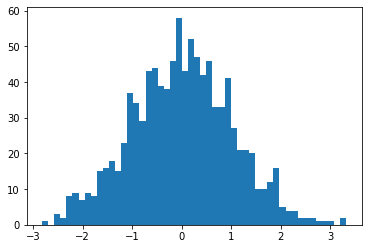

z shape: torch.Size([1000, 2])
w shape: torch.Size([2, 2])
P shape: torch.Size([1000, 1000])
pi shape:  torch.Size([1000, 1000, 2])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


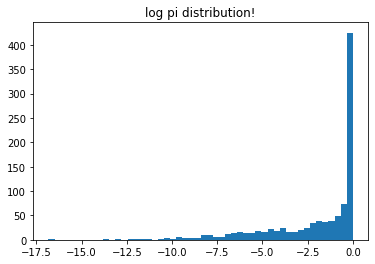

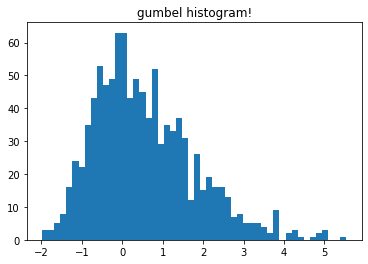

IndexError: too many indices for tensor of dimension 1

<Figure size 432x288 with 0 Axes>

In [6]:
import torch
from torch import nn
import torch.nn.functional as F


import numpy as np
import matplotlib.pyplot as plt

def gumbel_sampling(shape, mu=0, beta=1):
    y = torch.rand(shape) + 1e-25  # ensure all y is positive.
    g = mu - beta * torch.log(-torch.log(y))
    return g


def update_A(z, tau=0.01, W=None):
    """
    update A via node representation Z (N x N)
    """
    P = F.sigmoid(z@W@z.T)
    print('P shape:', P.shape)
    
    pi = torch.tensor(torch.stack((1-P, P),dim=2))
    print('pi shape: ', pi.shape)
#     g = gumbel_sampling(pi.shape)
    g = np.random.gumbel(size=pi.shape[0])
    log_pi = torch.log(pi)
    
    plt.figure()
    plt.hist(log_pi[0, :, 1], bins=50)
    plt.title('log pi distribution!')
    plt.show()
    
    U = (log_pi[0, :, 1] + g)/tau
    # plot:
    plt.figure()
#     plt.hist(g[0,:,1],bins=50)
    plt.hist(g,bins=50)
    plt.title('gumbel histogram!')
    plt.show()
    
    plt.figure()
    plt.hist(U[0,:,0], bins=50)
    plt.show()

    # TODO: Gumbel softmax sampling:
    A = F.softmax(U, dim=2)
    print('A : ', A[0, 0, :])
    plt.figure()
    plt.hist(A[0, :, 1], bins=50)
    plt.show()

    
z = torch.randn((1000, 2))


plt.figure()
plt.hist(z[:,1], bins=50)
plt.show()


w = torch.ones((2, 2))
print('z shape:', z.shape)
print('w shape:', w.shape)
update_A(z, tau=0.5, W=w)



In [9]:
t1 = torch.FloatTensor([[1,2],[5,6]])
t2 = torch.FloatTensor([[3,4],[7,8]])
l = [t1, t2]

t3 = torch.stack(l, dim=2)
print(t3.shape)
print(t3)

torch.Size([2, 2, 2])
tensor([[[1., 3.],
         [2., 4.]],

        [[5., 7.],
         [6., 8.]]])
